<a href="https://colab.research.google.com/github/FrancescoManca-FM/Project_MLDL/blob/main/incrementalLearningWithoutForgetting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms 
import torch.nn.functional as F
import copy
from torch.nn.init import xavier_uniform_ 
from torch.nn.init import kaiming_uniform_

### DATA LOADER

In [2]:
# we build a transform to normalize images: Data normalization is an important step which ensures 
# each input parameter (pixel, in this case) has a similar data distribution. This makes convergence 
# faster while training the network.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 128

trainset_raw = torchvision.datasets.CIFAR100(root='./data', train=True, 
                                         download=True, transform=transform)

for i in range(len(trainset_raw)):
  if(i==0):
    trainset = [[trainset_raw[i][0], trainset_raw[i][1]]]
  else:
    trainset.append([trainset_raw[i][0], trainset_raw[i][1]])


# DataLoader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# batch_size = how many samples per batch to load
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### NETWORK

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)

        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def addOutputNodes(self, num_new_outputs):
        in_features = self.fc.in_features
        out_features = self.fc.out_features
        weight = self.fc.weight.data

        self.fc = nn.Linear(in_features, out_features + num_new_outputs)

        #xavier initialization
        xavier_uniform_(self.fc.weight)
        
        self.fc.weight.data[:out_features] = weight
        


def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model

In [4]:
net = resnet32()
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
net.to(device)

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

### LOSS & PARAMETERS

In [5]:
lr = 0.001
decay = 0.0001
epochs = 40
momentum = 0.9
factor = 5

In [6]:
import torch.optim as optim
import torch.nn as nn


bceLoss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr = lr, weight_decay=decay,momentum= momentum)

### TRAINING BCE LOSS

In [7]:
def training(trainloader, iteration, network, device, epochs, num_classes):
  num_classes_till_previous_step = iteration * num_classes
  num_current_classes = num_classes_till_previous_step + num_classes
  total_classes = 100
  distillation_loss = 0
  old_net = copy.deepcopy(network)
  old_net.eval()
  
  if (iteration != 0):
    # add 10 output nodes to the network
    network.addOutputNodes(num_classes)
    network.to(device)

  optimizer = optim.SGD(network.parameters(), lr = lr, weight_decay=decay,momentum= momentum)
  print("before training: ", network.fc.weight.data)
 
  #train the network
  for epoch in range(epochs):
    #if (epoch == 49 or epoch == 63):
     # optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / factor

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs = data[0].to(device)
      labels = data[1].to(device)
      optimizer.zero_grad()
      logits = network.forward(inputs)
      distilled_targets = get_one_hot(labels, num_current_classes, device)
      
      if iteration > 0:
        logits_old = old_net(inputs)
        distilled_targets[:, 0:num_classes_till_previous_step] = torch.sigmoid(logits_old)

      loss = bceLoss(logits, distilled_targets) #* (num_current_classes / total_classes)

      # redesign the weights evaluating the performance of the network
      loss.backward()
      # update parameters
      optimizer.step()

      running_loss += loss.item()
      if i % 20 == 19:    
        print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 20))
        running_loss = 0.0

  return network

In [8]:
def get_one_hot(target,num_class, device):
  one_hot=torch.zeros(target.shape[0],num_class).to(device)
  one_hot=one_hot.scatter(dim=1,index=target.long().view(-1,1),value=1.)
  return one_hot

### TEST

In [9]:
"""
def test(testloader, iteration, network, acc):

  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
        
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))
  """

'\ndef test(testloader, iteration, network, acc):\n\n  correct = 0\n  total = 0\n  print("ITERATION: ", iteration)\n  \n  # since we\'re not training, we don\'t need to calculate the gradients for our outputs\n  with torch.no_grad():\n      for data in testloader:\n          images, labels = data[0].to(device), data[1].to(device)\n\n          # calculate outputs by running images through the network\n          outputs = network.forward(images)\n\n          # the class with the highest energy is what we choose as prediction\n          _, predicted = torch.max(outputs.data, 1)\n          total += labels.size(0)\n          correct += (predicted == labels).sum().item()\n         \n        \n  acc.append(100*correct/total)\n  print(f\'Accuracy of the network on the {iteration} iteration: %d %%\' % (100 * correct / total))\n  '

### EXECUTION 

In [10]:
"""
# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations= 10 
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []
import random
#indices = list(range(0,100))
#random.shuffle(indices)
for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = [] 
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])


  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time

  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration
  """

'\n# divided our dataset into sample of 10 classes each\n# train the network on the first 10 classes\n# evaluate the network on the first 10 classes\n# train the network on the second 10 classes (adding 10 output layers)\n# evaluate the network on the first 20 classes\niterations= 10 \nnum_classes = 10\ntest_set = [] #initialized here because we test over all the classes not only those one in which I train\nacc = []\nimport random\n#indices = list(range(0,100))\n#random.shuffle(indices)\nfor i in range(iterations):\n  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)\n  train_iter = [] \n  for j in range(len(trainset)):\n    if(trainset[j][-1] in classes_current_iter):\n      test_set.append(trainset[j]) \n      train_iter.append(trainset[j])\n\n\n  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)\n  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2

### CONFUSION MATRIX

In [11]:
"""
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

confusion_matrix = torch.zeros(100,100)

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valid_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net.forward(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for t, p in zip(labels.view(-1), predicted.view(-1)):
          confusion_matrix[t.long(),p.long()] += 1

plt.figure()
plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
"""

'\nfrom sklearn.metrics import plot_confusion_matrix\nimport matplotlib.pyplot as plt\n\nconfusion_matrix = torch.zeros(100,100)\n\ncorrect = 0\ntotal = 0\n# since we\'re not training, we don\'t need to calculate the gradients for our outputs\nwith torch.no_grad():\n    for data in valid_loader:\n        images, labels = data[0].to(device), data[1].to(device)\n        # calculate outputs by running images through the network\n        outputs = net.forward(images)\n        # the class with the highest energy is what we choose as prediction\n        _, predicted = torch.max(outputs.data, 1)\n        total += labels.size(0)\n        correct += (predicted == labels).sum().item()\n\n        for t, p in zip(labels.view(-1), predicted.view(-1)):\n          confusion_matrix[t.long(),p.long()] += 1\n\nplt.figure()\nplt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)\nprint(\'Accuracy of the network on the 10000 test images: %d %%\' % (100 * correct / total))\n'

### TEST (CONFUSION EACH STEP)



In [12]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

def test(testloader, iteration, network, acc):
  confusion_matrix = torch.zeros(iteration*10+10,iteration*10+10)
  print("confusion matrix shape: ", confusion_matrix.shape)
  correct = 0
  total = 0
  print("ITERATION: ", iteration)
  
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)

          # calculate outputs by running images through the network
          outputs = network.forward(images)

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
         
          for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion_matrix[t.long(),p.long()] += 1

  plt.figure()
  plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.jet)
  plt.show()
  acc.append(100*correct/total)
  print(f'Accuracy of the network on the {iteration} iteration: %d %%' % (100 * correct / total))

### RANDOM CLASSES


EXECUTION

In [13]:
import random
indices = list(range(0,100))
random.shuffle(indices)
dict_classes = dict(zip(indices,range(100)))
for i in range(len(trainset)):
  trainset[i][1] = dict_classes[trainset[i][1]]

Train the network, iteration:  0  on classes:  range(0, 10)
before training:  tensor([[ 0.0539, -0.0505,  0.0644, -0.1029,  0.1084,  0.0950,  0.0559,  0.0757,
         -0.1052,  0.0342, -0.1132, -0.0322,  0.1163, -0.0337,  0.0509, -0.0141,
         -0.0385, -0.0823,  0.1070,  0.0189,  0.0756,  0.0814,  0.1245,  0.0705,
         -0.0130, -0.0132,  0.0473, -0.0155, -0.0916, -0.0891,  0.0522, -0.0539,
          0.0802,  0.0718,  0.0839, -0.1133,  0.0074, -0.1117,  0.0077,  0.1037,
         -0.0322,  0.0015, -0.0353, -0.0067,  0.0529,  0.0374,  0.0857,  0.0271,
         -0.0181,  0.0379,  0.0361, -0.0790, -0.0756,  0.0478,  0.0188, -0.0196,
         -0.1053,  0.0592,  0.1193, -0.0843,  0.0706, -0.0212,  0.1004, -0.1002],
        [ 0.0451,  0.0493,  0.1156,  0.0192,  0.0416,  0.0568,  0.0349,  0.1127,
          0.0724,  0.0668,  0.0930, -0.0333, -0.0101,  0.0998,  0.0537,  0.0423,
          0.0983,  0.0393, -0.1236,  0.1195,  0.0632,  0.0016,  0.0979,  0.0343,
          0.1036, -0.0930, -0.

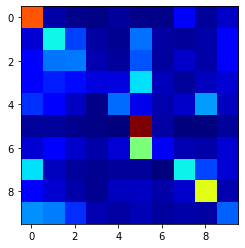

Accuracy of the network on the 0 iteration: 35 %
Train the network, iteration:  1  on classes:  range(10, 20)
before training:  tensor([[ 7.7678e-04, -1.3883e-01,  4.8367e-02,  ..., -4.2605e-02,
          8.3194e-02, -1.4051e-01],
        [ 1.7293e-02, -4.2144e-05,  6.7723e-02,  ..., -1.9984e-02,
         -8.1349e-02, -1.0377e-01],
        [-5.5934e-02, -1.2156e-01, -1.7069e-02,  ...,  7.0219e-03,
         -5.0408e-02,  1.2374e-04],
        ...,
        [ 7.1722e-02, -9.4230e-02, -8.5001e-02,  ...,  1.6192e-01,
          2.9417e-02,  2.1405e-01],
        [ 8.1716e-02, -2.2138e-01, -2.2120e-01,  ..., -9.8038e-02,
          2.6240e-01, -5.5975e-02],
        [ 1.2072e-01, -1.0832e-01, -1.2256e-01,  ...,  1.3486e-01,
          1.2915e-01, -2.5942e-01]], device='cuda:0')
[1,    20] loss: 1.038
[1,    40] loss: 0.846
[2,    20] loss: 0.660
[2,    40] loss: 0.522
[3,    20] loss: 0.439
[3,    40] loss: 0.388
[4,    20] loss: 0.359
[4,    40] loss: 0.342
[5,    20] loss: 0.332
[5,    40] loss:

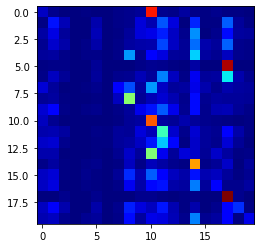

Accuracy of the network on the 1 iteration: 20 %
Train the network, iteration:  2  on classes:  range(20, 30)
before training:  tensor([[ 3.5201e-03, -1.3700e-01,  5.2716e-02,  ..., -3.9172e-02,
          8.7979e-02, -1.3838e-01],
        [ 2.1468e-02,  6.2198e-03,  6.5837e-02,  ..., -1.8460e-02,
         -8.2011e-02, -9.8977e-02],
        [-5.8183e-02, -1.2264e-01, -1.6431e-02,  ...,  8.1195e-03,
         -5.0941e-02, -1.7164e-03],
        ...,
        [-2.4252e-01, -1.5338e-01,  1.2405e-01,  ..., -1.2678e-01,
          8.7292e-03,  2.4392e-01],
        [-1.9184e-01, -1.3720e-01,  4.5263e-02,  ...,  5.2304e-02,
          1.3872e-01, -8.3713e-02],
        [-3.8089e-03,  1.6667e-01,  1.3920e-04,  ...,  3.2308e-03,
          1.0707e-01, -2.4793e-01]], device='cuda:0')
[1,    20] loss: 0.527
[1,    40] loss: 0.472
[2,    20] loss: 0.425
[2,    40] loss: 0.392
[3,    20] loss: 0.368
[3,    40] loss: 0.354
[4,    20] loss: 0.344
[4,    40] loss: 0.335
[5,    20] loss: 0.330
[5,    40] loss:

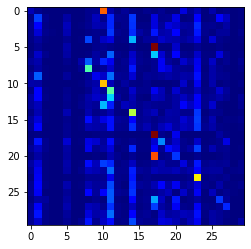

Accuracy of the network on the 2 iteration: 15 %
Train the network, iteration:  3  on classes:  range(30, 40)
before training:  tensor([[ 3.9777e-03, -1.3724e-01,  4.8776e-02,  ..., -4.2661e-02,
          8.3544e-02, -1.3897e-01],
        [ 2.4076e-02,  8.4011e-03,  6.9403e-02,  ..., -1.5821e-02,
         -7.8110e-02, -9.6434e-02],
        [-5.5397e-02, -1.2130e-01, -1.2894e-02,  ...,  9.7704e-03,
         -4.7296e-02, -1.8909e-04],
        ...,
        [ 9.0639e-02, -2.3314e-01, -1.7846e-01,  ...,  4.0329e-02,
         -2.9101e-03,  6.2108e-04],
        [ 3.3769e-02, -1.7335e-01, -1.1311e-01,  ...,  2.2243e-01,
         -7.2981e-02, -1.2946e-01],
        [-3.8101e-03,  2.0018e-01,  1.7391e-01,  ...,  1.1760e-01,
         -1.8380e-01,  1.8226e-01]], device='cuda:0')
[1,    20] loss: 0.521
[1,    40] loss: 0.490
[2,    20] loss: 0.457
[2,    40] loss: 0.429
[3,    20] loss: 0.405
[3,    40] loss: 0.388
[4,    20] loss: 0.371
[4,    40] loss: 0.359
[5,    20] loss: 0.348
[5,    40] loss:

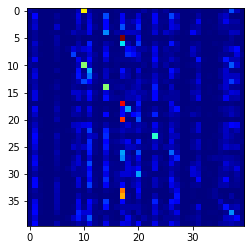

Accuracy of the network on the 3 iteration: 10 %
Train the network, iteration:  4  on classes:  range(40, 50)
before training:  tensor([[ 0.0038, -0.1373,  0.0489,  ..., -0.0429,  0.0833, -0.1385],
        [ 0.0224,  0.0068,  0.0691,  ..., -0.0152, -0.0782, -0.0985],
        [-0.0511, -0.1182, -0.0111,  ...,  0.0118, -0.0444,  0.0028],
        ...,
        [ 0.1779,  0.1478, -0.1144,  ...,  0.0298,  0.0214, -0.1651],
        [ 0.1910, -0.1326,  0.0719,  ..., -0.1185,  0.2269, -0.0720],
        [-0.2105,  0.0195, -0.0665,  ..., -0.0384,  0.0912, -0.0206]],
       device='cuda:0')
[1,    20] loss: 0.442
[1,    40] loss: 0.422
[2,    20] loss: 0.401
[2,    40] loss: 0.384
[3,    20] loss: 0.371
[3,    40] loss: 0.360
[4,    20] loss: 0.353
[4,    40] loss: 0.346
[5,    20] loss: 0.341
[5,    40] loss: 0.338
[6,    20] loss: 0.334
[6,    40] loss: 0.333
[7,    20] loss: 0.331
[7,    40] loss: 0.328
[8,    20] loss: 0.328
[8,    40] loss: 0.326
[9,    20] loss: 0.326
[9,    40] loss: 0.324


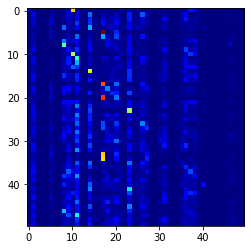

Accuracy of the network on the 4 iteration: 8 %
Train the network, iteration:  5  on classes:  range(50, 60)
before training:  tensor([[ 0.0052, -0.1356,  0.0500,  ..., -0.0413,  0.0845, -0.1367],
        [ 0.0230,  0.0075,  0.0687,  ..., -0.0159, -0.0784, -0.0976],
        [-0.0520, -0.1182, -0.0115,  ...,  0.0118, -0.0449,  0.0024],
        ...,
        [ 0.0748, -0.0991, -0.0926,  ..., -0.0414, -0.2009, -0.2164],
        [-0.0627,  0.1517,  0.0762,  ...,  0.2180, -0.1163, -0.1051],
        [ 0.0064,  0.0760,  0.0237,  ..., -0.0190, -0.2193, -0.1409]],
       device='cuda:0')
[1,    20] loss: 0.407
[1,    40] loss: 0.395
[2,    20] loss: 0.382
[2,    40] loss: 0.370
[3,    20] loss: 0.363
[3,    40] loss: 0.355
[4,    20] loss: 0.350
[4,    40] loss: 0.345
[5,    20] loss: 0.341
[5,    40] loss: 0.338
[6,    20] loss: 0.335
[6,    40] loss: 0.333
[7,    20] loss: 0.331
[7,    40] loss: 0.330
[8,    20] loss: 0.329
[8,    40] loss: 0.328
[9,    20] loss: 0.326
[9,    40] loss: 0.326
[

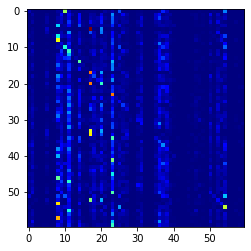

Accuracy of the network on the 5 iteration: 7 %
Train the network, iteration:  6  on classes:  range(60, 70)
before training:  tensor([[ 0.0059, -0.1351,  0.0489,  ..., -0.0429,  0.0834, -0.1366],
        [ 0.0221,  0.0068,  0.0669,  ..., -0.0186, -0.0802, -0.0985],
        [-0.0537, -0.1194, -0.0133,  ...,  0.0090, -0.0471,  0.0004],
        ...,
        [ 0.0578,  0.1321,  0.0960,  ...,  0.0170,  0.1696,  0.0996],
        [ 0.0263,  0.0239,  0.1567,  ..., -0.1226, -0.0689,  0.1877],
        [ 0.1357, -0.2073,  0.1230,  ..., -0.1426,  0.1856, -0.1318]],
       device='cuda:0')
[1,    20] loss: 0.390
[1,    40] loss: 0.383
[2,    20] loss: 0.375
[2,    40] loss: 0.368
[3,    20] loss: 0.361
[3,    40] loss: 0.356
[4,    20] loss: 0.352
[4,    40] loss: 0.349
[5,    20] loss: 0.346
[5,    40] loss: 0.343
[6,    20] loss: 0.341
[6,    40] loss: 0.340
[7,    20] loss: 0.337
[7,    40] loss: 0.336
[8,    20] loss: 0.335
[8,    40] loss: 0.335
[9,    20] loss: 0.334
[9,    40] loss: 0.332
[

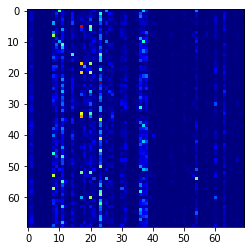

Accuracy of the network on the 6 iteration: 6 %
Train the network, iteration:  7  on classes:  range(70, 80)
before training:  tensor([[ 0.0062, -0.1345,  0.0494,  ..., -0.0425,  0.0837, -0.1359],
        [ 0.0240,  0.0083,  0.0681,  ..., -0.0179, -0.0786, -0.0966],
        [-0.0516, -0.1174, -0.0123,  ...,  0.0091, -0.0458,  0.0022],
        ...,
        [ 0.1095, -0.0057, -0.1899,  ..., -0.0901, -0.1483, -0.0551],
        [-0.1003,  0.0247, -0.1676,  ...,  0.0531, -0.0749, -0.1755],
        [ 0.1337,  0.0582,  0.0812,  ..., -0.0281,  0.1058,  0.0935]],
       device='cuda:0')
[1,    20] loss: 0.436
[1,    40] loss: 0.426
[2,    20] loss: 0.415
[2,    40] loss: 0.404
[3,    20] loss: 0.396
[3,    40] loss: 0.388
[4,    20] loss: 0.380
[4,    40] loss: 0.374
[5,    20] loss: 0.369
[5,    40] loss: 0.364
[6,    20] loss: 0.360
[6,    40] loss: 0.356
[7,    20] loss: 0.353
[7,    40] loss: 0.351
[8,    20] loss: 0.348
[8,    40] loss: 0.346
[9,    20] loss: 0.345
[9,    40] loss: 0.342
[

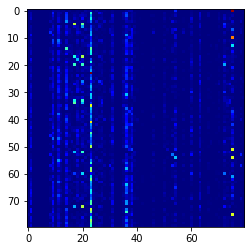

Accuracy of the network on the 7 iteration: 5 %
Train the network, iteration:  8  on classes:  range(80, 90)
before training:  tensor([[ 0.0056, -0.1343,  0.0491,  ..., -0.0421,  0.0833, -0.1359],
        [ 0.0262,  0.0105,  0.0699,  ..., -0.0159, -0.0763, -0.0937],
        [-0.0510, -0.1163, -0.0118,  ...,  0.0096, -0.0453,  0.0032],
        ...,
        [-0.1487, -0.0924,  0.0440,  ...,  0.0772,  0.1869, -0.1879],
        [-0.1896,  0.0246, -0.1901,  ..., -0.0834, -0.0998, -0.0218],
        [ 0.0027,  0.1421, -0.0691,  ..., -0.0077,  0.1902,  0.1604]],
       device='cuda:0')
[1,    20] loss: 0.392
[1,    40] loss: 0.387
[2,    20] loss: 0.380
[2,    40] loss: 0.373
[3,    20] loss: 0.369
[3,    40] loss: 0.364
[4,    20] loss: 0.359
[4,    40] loss: 0.356
[5,    20] loss: 0.353
[5,    40] loss: 0.350
[6,    20] loss: 0.347
[6,    40] loss: 0.347
[7,    20] loss: 0.344
[7,    40] loss: 0.342
[8,    20] loss: 0.341
[8,    40] loss: 0.339
[9,    20] loss: 0.338
[9,    40] loss: 0.338
[

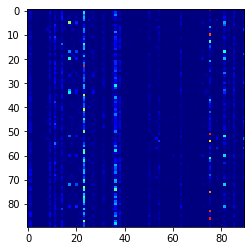

Accuracy of the network on the 8 iteration: 4 %
Train the network, iteration:  9  on classes:  range(90, 100)
before training:  tensor([[ 0.0076, -0.1324,  0.0513,  ..., -0.0400,  0.0855, -0.1333],
        [ 0.0280,  0.0125,  0.0706,  ..., -0.0148, -0.0751, -0.0912],
        [-0.0516, -0.1163, -0.0128,  ...,  0.0089, -0.0462,  0.0026],
        ...,
        [-0.1375, -0.0319,  0.1279,  ...,  0.1750, -0.0682, -0.1871],
        [-0.0984,  0.1474,  0.0694,  ..., -0.0554, -0.1284,  0.1565],
        [-0.0438, -0.0210, -0.0144,  ...,  0.0662, -0.1522,  0.1833]],
       device='cuda:0')
[1,    20] loss: 0.393
[1,    40] loss: 0.388
[2,    20] loss: 0.382
[2,    40] loss: 0.376
[3,    20] loss: 0.372
[3,    40] loss: 0.368
[4,    20] loss: 0.364
[4,    40] loss: 0.361
[5,    20] loss: 0.358
[5,    40] loss: 0.356
[6,    20] loss: 0.353
[6,    40] loss: 0.352
[7,    20] loss: 0.350
[7,    40] loss: 0.348
[8,    20] loss: 0.347
[8,    40] loss: 0.346
[9,    20] loss: 0.345
[9,    40] loss: 0.343


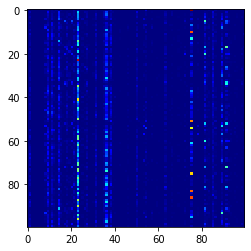

Accuracy of the network on the 9 iteration: 3 %


In [14]:
#TRYING TO RANDOMIZE CLASSES


# divided our dataset into sample of 10 classes each
# train the network on the first 10 classes
# evaluate the network on the first 10 classes
# train the network on the second 10 classes (adding 10 output layers)
# evaluate the network on the first 20 classes
iterations = 10
num_classes = 10
test_set = [] #initialized here because we test over all the classes not only those one in which I train
acc = []

for i in range(iterations):
  classes_current_iter = range(i*num_classes, i*num_classes+num_classes)
  train_iter = []
  for j in range(len(trainset)):
    if(trainset[j][-1] in classes_current_iter):
      test_set.append(trainset[j]) 
      train_iter.append(trainset[j])

  train_loader = torch.utils.data.DataLoader(train_iter, shuffle = True, batch_size=batch_size, num_workers=2)
  valid_loader = torch.utils.data.DataLoader(test_set, shuffle = True, batch_size = batch_size, num_workers=2) 
  print("Train the network, iteration: ", i, " on classes: ", classes_current_iter)
  
  net = training(train_loader, i, net, device, epochs, num_classes) # Train the network with 10 classes at a time
  print("after training: ", net.fc.weight.data)
  test(valid_loader, i, net, acc) # Test the network with all classes seen until this iteration